# Example 1

This is an example that reproduces Figures 2,3 from the main text.
We generate synthetic data from the ramping dynamics (with linear potential), visualize the generated spikes and latent trajectories, and optimize a model on the generated data. We also demonstrate the importance of various non-stationary components for accurate model inference. This code is adopted for neuralflow version 3.

In [1]:
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
import logging
from neuralflow.utilities.visualization_functions import plot_spikes, plot_fitting_results
logging.basicConfig(level=logging.INFO)

## Step 1: Generate synthetic data

1) Specify grid parameters: number of points per element and number of elemets. 

2) Specify the ground-truth model for data generation, see the peq_models and firing_rate_models for built-in options. As described in the paper, we generate the data from the ramping dynamics, with noise magnitude $D=0.56$, and narrow zero-centered initial distribution of the latent states. 

2) Initialize data generator. We use absorbing boundary mode so that each trial ends at the decision boundary. Here we will generate 200 trials of data, each trial will have 100 seconds maximum duration (however, all of them will terminate earlier due to absorption at the decision boundary, with the average trial duration time less than 1 second). 

3) Perform data generation

4) (OPTIONAL) Visualize latent trajectories and spike rasters of the generated data. First of all, for each of the 200 generated latent trajectories, find the termination side (left or right boundary). Select 3 example trials where the latent trajectory terminated on the left, and 6 trials where the latent trajectory terminated on the right boundary. Plot latent trajectories and the corresponding spike rasters for the example nine trials.

In [2]:
grid = neuralflow.GLLgrid(Np = 8, Ne = 64)
gt_model = neuralflow.model.new_model(
    peq_model = {"model": "linear_pot", "params": {"slope": -2.65}},
    p0_model = {"model": "single_well", "params": {"miu": 200, "xmin": 0}},
    D = 0.56,
    fr_model = [{"model": "linear", "params": {"slope": 50, "bias": 60}}],
    grid = grid
)

data_generator = neuralflow.SyntheticData(gt_model, 'absorbing')

data, time_bins, diff_traj = data_generator.generate_data(trial_start = 0, trial_end = 100, num_trials = 200)

100%|██████████| 200/200 [00:15<00:00, 13.07it/s]


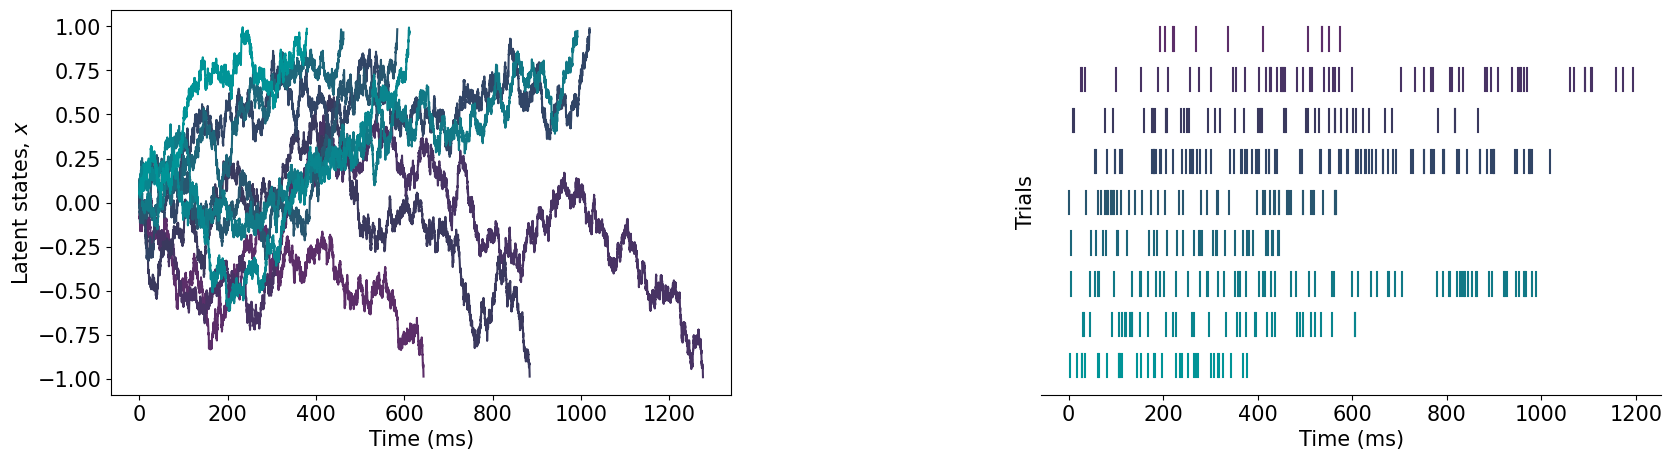

In [3]:
#(OPTIONAL): Visualize the latent trajectories and spike rasters of the generated data
fig=plt.figure(figsize=(20,5))
gs=gridspec.GridSpec(1,2,wspace=0.5)
colors=[[0, 0.5804, 0.5922], [0.0353, 0.5216, 0.5569], [0.0667, 0.4745, 0.5255],
[0.1137, 0.4000, 0.4784], [0.1569, 0.3373, 0.4353], [0.1922, 0.2706, 0.4000],
[0.2275, 0.2235, 0.3686], [0.2824, 0.2000, 0.3922], [0.3608, 0.1804, 0.4118]]
colors.reverse()

#Find where each of the latent trajectories teminate (1 if the right boundary, -1 if the left boundary):
bnd=np.array([1 if traj[-1]>0 else -1 for traj in diff_traj])

# Take 3 example trajectories that terminate on the left boundary, and 6 that terminate on the right boundary
if np.where(bnd==-1)[0].size<3:
    print(
        'Due to bad luck there are less than 3 trials out of 200 that terminate on the left boundary. Please rerun the previous cell to generate new data, and then '
        'rerun this cell'
    )
traj_indeces=np.concatenate((np.where(bnd==-1)[0][:3],np.where(bnd==1)[0][:6]))

#Plot latent trajectories
ax = plt.subplot(gs[0])
for i in range(9):
    plt.plot(time_bins[traj_indeces[i]]*1000,diff_traj[traj_indeces[i]],color=colors[i])
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel(r'Latent states, $x$',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = plt.subplot(gs[1])

#Plot spikes
plot_spikes(data[list(traj_indeces)],ax,colors)

plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel('Trials',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

## Step 2: Optimize model potential using the generated data 

1) Specify the model for the initial guess. All parameters are the same as the ground-truth, but the initial guess for potential is the constant potential (uniform peq model). To accelerate the evaluation of this cell, we also reduce grid resolution.

2) Convert the training data into SpikeData class that can be accepted by the optimizer.

3) Specify optimization parameters: maximum number of epochs, mini_batch_number that determine number of mini batches in the epoch (number of iterations per epoch), params_to_opt - a list of parameters to be optimized, and learning_rate - a dictionary that specify gradient-descent learning rates.

4) Initialize optimization object. optimizer_name is GD (gradient-descent), boundary mode is absorbing. 

3) Optimize the model with the selected parameters.


In [4]:
initial_guess_model = neuralflow.model.new_model(
    peq_model = {"model": "uniform", "params": {}},
    p0_model = {"model": "single_well", "params": {"miu": 200, "xmin": 0}},
    D = 0.56,
    fr_model = [{"model": "linear", "params": {"slope": 50, "bias": 60}}],
    grid = neuralflow.GLLgrid(Np = 8, Ne = 16)
)

dataTR = neuralflow.SpikeData(data)

opt_params = {'max_epochs': 50, 'mini_batch_number': 1, 'params_to_opt': 'F', 'learning_rate': {'F': 0.005}}

optimization = neuralflow.Optimization(dataTR, init_model = initial_guess_model, optimizer_name = 'GD', opt_options = opt_params, boundary_mode='absorbing')

optimization.run_optimization()

INFO:neuralflow.base_optimizer:Path is not specified. The results will only be saved in RAM
INFO:neuralflow.base_optimizer:sim_start not provided, setting to zero
INFO:neuralflow.base_optimizer:Setting saving schedule to default: save every epoch
100%|██████████| 50/50 [01:03<00:00,  1.27s/it]
INFO:neuralflow.optimization:Optimization completed


Visualize the results. In addition, we compute negative loglikelihood of the ground-truth model. Since the ground-truth model has different grid resolution than a training model, we create a grad object with the specific grid resolution that allows us to compute gradients for arbitrary data and models.

INFO:matplotlib.mathtext:Substituting symbol L from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol L from STIXGeneral


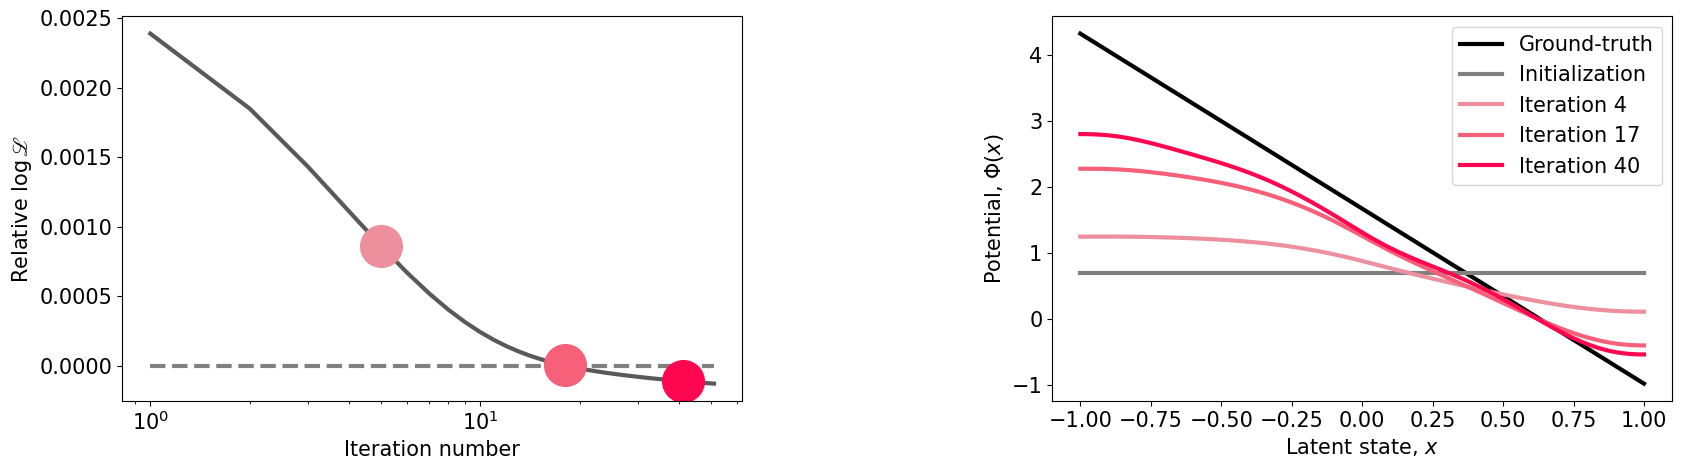

In [5]:
# Compute ground-truth loglik
# Need a new gradient object to compute the loglik, since the gt_model and initial_guess_model have different grid resolution.
# Thus, simply running optimization.optimizer.grad.get_grad_data(optimization.optimizer.get_dataTR(0), gt_model, 0) will fail.
grad = neuralflow.Grads(pde_solve_params = {'Np': grid.Np, 'Ne': grid.Ne}, boundary_mode = 'absorbing',)
ll_gt = grad.get_grad_data(optimization.optimizer.get_dataTR(0), gt_model, 0)
rel_lls = (ll_gt-optimization.results['logliks'][0])/ll_gt

# #Visualise the results
example_iterations=[4,17,40]
fig=plt.figure(figsize=(20,5))
gs=gridspec.GridSpec(1,2,wspace=0.5)
colors=[[0.9294, 0.5608, 0.6157], [0.9686, 0.3765, 0.4745], [1.0000, 0.0235, 0.3176]]
plot_fitting_results(gs[0],gs[1], initial_guess_model, optimization.results, gt_model, ll_gt,example_iterations,colors)

## Step 3: Testing the contributions of non-stationary components
Here we will use the same data as in the previous step to demonstrate the importance of various non-stationary components. Note that the purpose of this task is to demonstrate the deterioration of the fitting results when one or more non-stationary components are missing (and, therefore, this setting should not be used for data analysis when the goal is inferring the correct model).

1) Same as in Step 2, but the inference is performed without the absorption operator.

2) Same as in Step 2, but the inference is performed with reflective boundary conditions (and without the absorption operator).

3) Same as in Step 2, but the inference is performed with reflective boundary conditions, and starting from the equilibrium probability distribution density of the latent states.

Visualize the results. Note that Figure 3 in the main text was generated under slightly different ground-truth model parameters so that the position of the ground-truth loglikelihood (dashed line) can differ. However, the spurious features of the potential are qualitatively similar to Figure 3 in the paper. 



INFO:neuralflow.base_optimizer:Path is not specified. The results will only be saved in RAM
INFO:neuralflow.base_optimizer:sim_start not provided, setting to zero
INFO:neuralflow.base_optimizer:Setting saving schedule to default: save every epoch


Starting optimization 1 (no absorption operator)...


100%|██████████| 50/50 [01:05<00:00,  1.32s/it]
INFO:neuralflow.optimization:Optimization completed
INFO:neuralflow.base_optimizer:Path is not specified. The results will only be saved in RAM
INFO:neuralflow.base_optimizer:sim_start not provided, setting to zero
INFO:neuralflow.base_optimizer:Setting saving schedule to default: save every epoch


Starting optimization 2 (no absorption operator, reflecting BCs)...


100%|██████████| 50/50 [01:13<00:00,  1.46s/it]
INFO:neuralflow.optimization:Optimization completed
INFO:neuralflow.base_optimizer:Path is not specified. The results will only be saved in RAM
INFO:neuralflow.base_optimizer:sim_start not provided, setting to zero
INFO:neuralflow.base_optimizer:Setting saving schedule to default: save every epoch


Starting optimization 3 (no absorption operator, reflecting BCs, trials start at equilibrium)...


100%|██████████| 50/50 [01:13<00:00,  1.46s/it]
INFO:neuralflow.optimization:Optimization completed


Text(0.5, 0.27, 'The inference without the absorption operator, reflecting BCs, and with equilibrium probability distribution of the initial latent states')

INFO:matplotlib.mathtext:Substituting symbol L from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol L from STIXGeneral


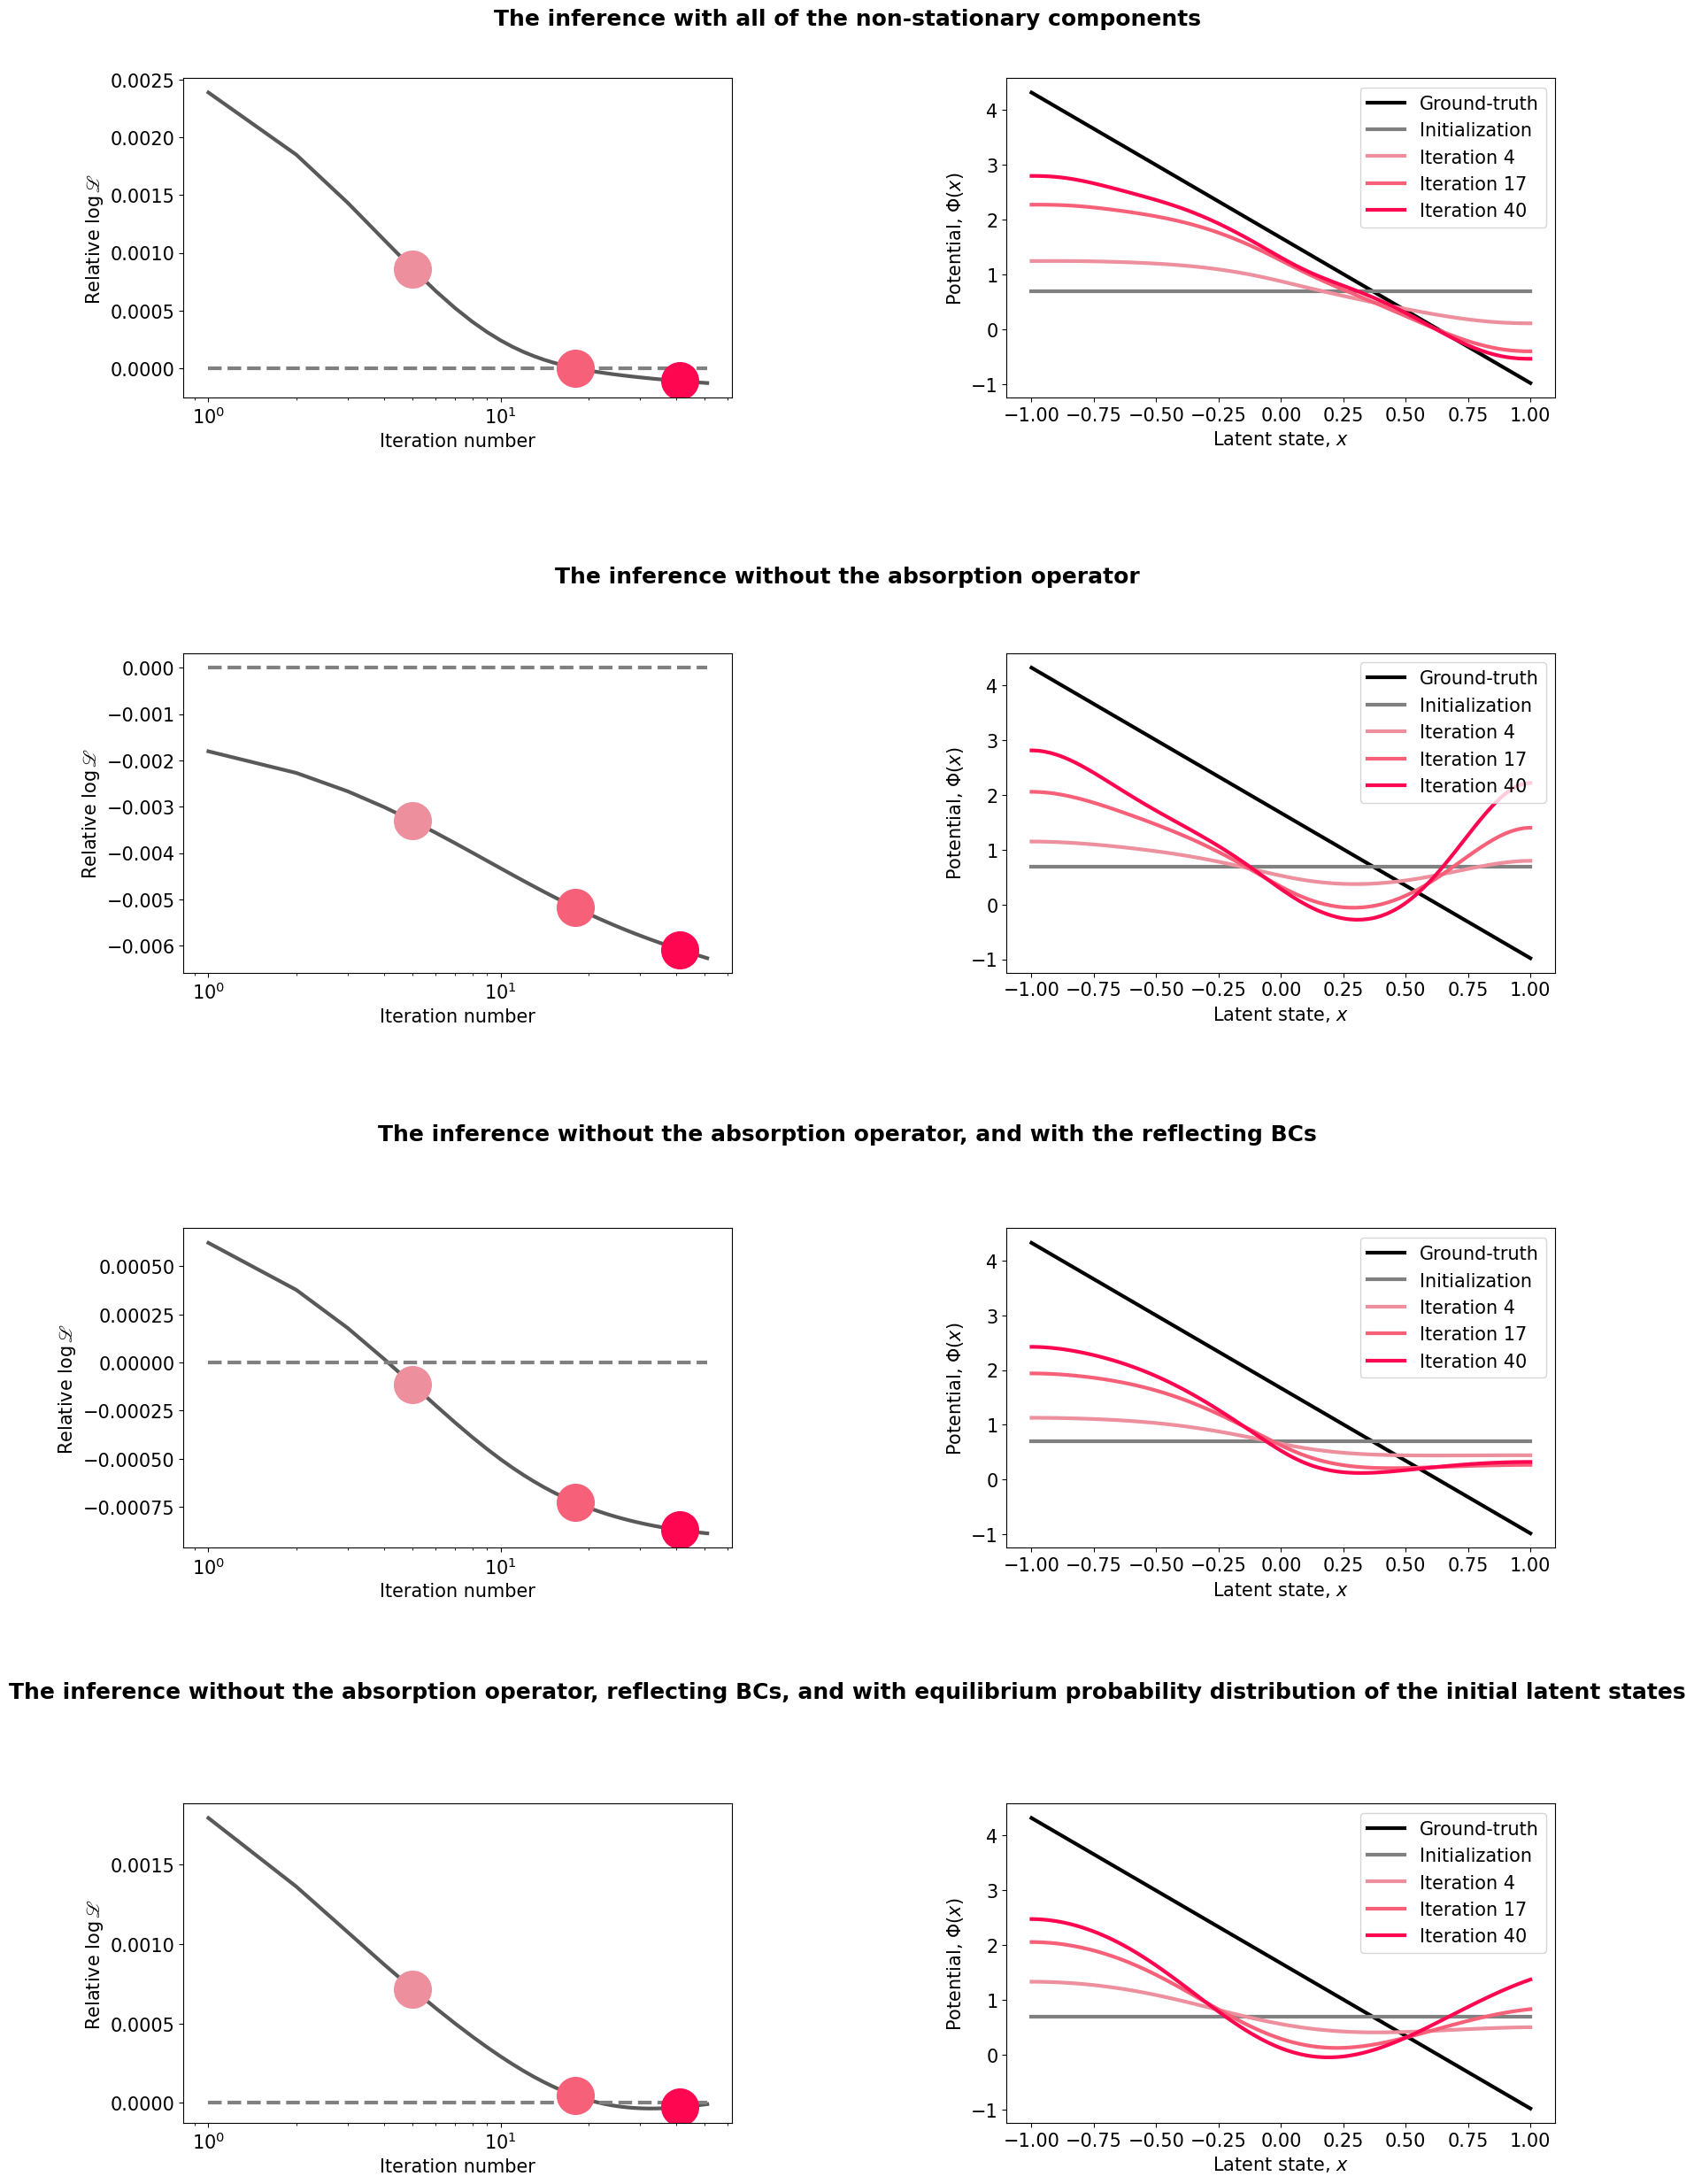

In [6]:
#Create a big figure to plot all the results
fig=plt.figure(figsize=(20,30))
gs=gridspec.GridSpec(4,2,wspace=0.5,hspace=0.8);

# Plot the results from the previous cell
plot_fitting_results(gs[0],gs[1], initial_guess_model, optimization.results, gt_model, ll_gt,example_iterations,colors)
fig.text(0.5,0.9,'The inference with all of the non-stationary components',fontsize=18,horizontalalignment='center',fontweight='bold')

# Optimize the data using reflecting boundary mode (thus, without the absorption operator), but enforcing dirichlet (absorbing) boundary conditions in the PDE solver
optimization = neuralflow.Optimization(dataTR, init_model = initial_guess_model, optimizer_name = 'GD', opt_options = opt_params, 
                                       pde_solve_params={'BoundCond': {'leftB': 'Dirichlet', 'rightB': 'Dirichlet'}}, boundary_mode='reflecting')
print('Starting optimization 1 (no absorption operator)...')
optimization.run_optimization()
# Compute the likelihood of the ground-truth model using this setting
grad = neuralflow.Grads(pde_solve_params = {'Np': grid.Np, 'Ne': grid.Ne, 'BoundCond': {'leftB': 'Dirichlet', 'rightB': 'Dirichlet'}}, boundary_mode = 'reflecting')
ll_gt = grad.get_grad_data(optimization.optimizer.get_dataTR(0), gt_model, 0)
plot_fitting_results(gs[2],gs[3], initial_guess_model, optimization.results, gt_model, ll_gt,example_iterations,colors)
fig.text(0.5,0.69,'The inference without the absorption operator',fontsize=18,horizontalalignment='center',fontweight='bold')

# Now enforce reflecting mode in both PDE and inference. In this case PDE will be solved with Neumann BC, and also absorption operator will not be applied.
optimization = neuralflow.Optimization(dataTR, init_model = initial_guess_model, optimizer_name = 'GD', opt_options = opt_params, boundary_mode='reflecting')
print('Starting optimization 2 (no absorption operator, reflecting BCs)...')
optimization.run_optimization()
grad = neuralflow.Grads(pde_solve_params = {'Np': grid.Np, 'Ne': grid.Ne}, boundary_mode = 'reflecting')
ll_gt = grad.get_grad_data(optimization.optimizer.get_dataTR(0), gt_model, 0)
plot_fitting_results(gs[4],gs[5], initial_guess_model, optimization.results, gt_model, ll_gt,example_iterations,colors)
fig.text(0.5,0.48,'The inference without the absorption operator, and with the reflecting BCs',fontsize=18,horizontalalignment='center',fontweight='bold')

# Now initialize an equilibrium model by setting p0 to None.
initial_guess_model = neuralflow.model.new_model(
    peq_model = {"model": "uniform", "params": {}},
    p0_model = None,
    D = 0.56,
    fr_model = [{"model": "linear", "params": {"slope": 50, "bias": 60}}],
    grid = neuralflow.GLLgrid(Np = 8, Ne = 16)
)
optimization = neuralflow.Optimization(dataTR, init_model = initial_guess_model, optimizer_name = 'GD', opt_options = opt_params, boundary_mode='reflecting')
print('Starting optimization 3 (no absorption operator, reflecting BCs, trials start at equilibrium)...')
optimization.run_optimization()
# Do not recompute ground-truth likelihood, as the ground-truth model was non-stationary
plot_fitting_results(gs[6],gs[7], initial_guess_model, optimization.results, gt_model, ll_gt,example_iterations,colors)
fig.text(0.5,0.27,'The inference without the absorption operator, reflecting BCs, and with equilibrium probability distribution of the initial latent states',fontsize=18,horizontalalignment='center',fontweight='bold')